In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
file_path = "room_bookings.xlsx"
df = pd.read_excel(file_path)

In [3]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday  # Monday = 0, Sunday = 6

In [29]:
# Show basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-01-01 to 2024-12-31
Freq: D
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Day                  731 non-null    int32
 1   Month                731 non-null    int32
 2   AC Rooms Booked      731 non-null    int64
 3   Non-AC Rooms Booked  731 non-null    int64
 4   Total Bookings       731 non-null    int64
 5   Year                 731 non-null    int32
 6   Weekday              731 non-null    int32
dtypes: int32(4), int64(3)
memory usage: 34.3 KB


In [28]:
df.describe()

,Day,Month,AC Rooms Booked,Non-AC Rooms Booked,Total Bookings,Year,Weekday
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,15.738714,6.519836,5.378933,6.259918,11.638851,2023.500684,2.997264
std,8.809949,3.451913,2.332626,3.083455,2.838255,0.500342,2.004787
min,1.000000,1.000000,2.000000,2.000000,6.000000,2023.000000,0.000000
25%,8.000000,4.000000,4.000000,4.000000,9.000000,2023.000000,1.000000
50%,16.000000,7.000000,4.000000,5.000000,12.000000,2024.000000,3.000000
75%,23.000000,10.000000,7.000000,10.000000,15.000000,2024.000000,5.000000
max,31.000000,12.000000,10.000000,11.000000,15.000000,2024.000000,6.000000


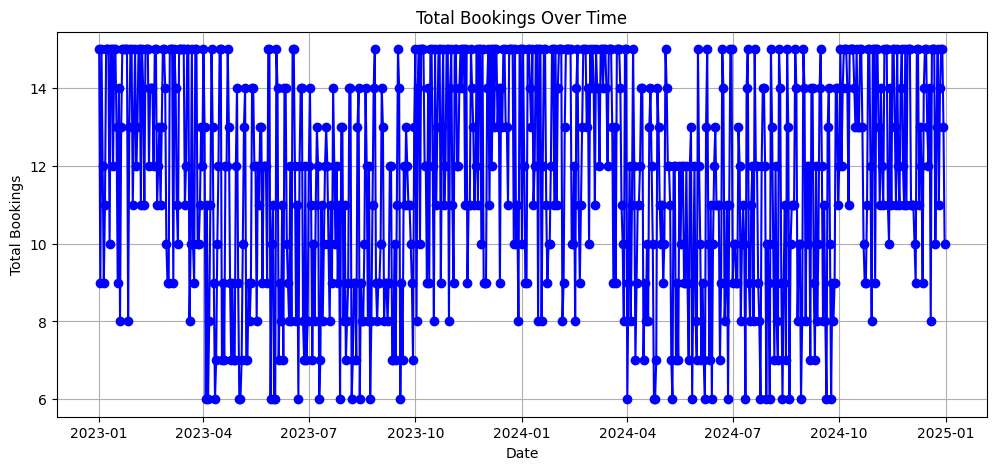

In [7]:
# Time series plot
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Total Bookings"], marker="o", linestyle="-", color="b")
plt.xlabel("Date")
plt.ylabel("Total Bookings")
plt.title("Total Bookings Over Time")
plt.grid()
plt.show()

C:\Users\Bablu\AppData\Local\Temp\ipykernel_10068\2646935808.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm")


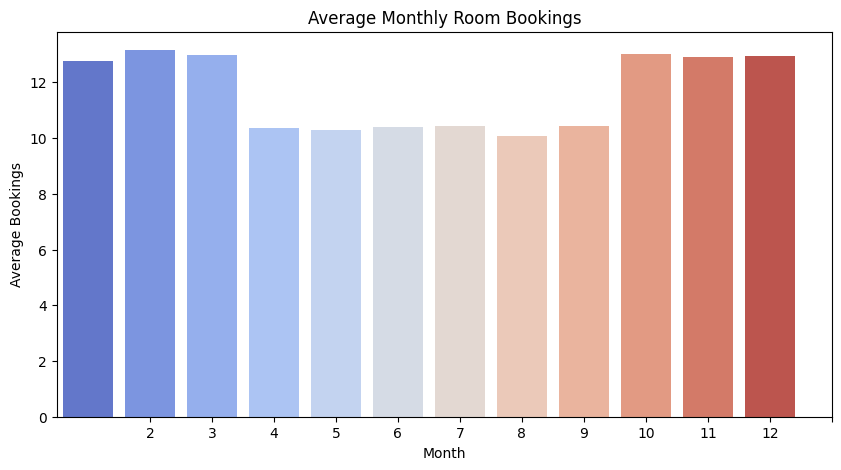

In [8]:
# Monthly Trend Analysis
monthly_avg = df.groupby("Month")["Total Bookings"].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Average Bookings")
plt.title("Average Monthly Room Bookings")
plt.xticks(range(1, 13))
plt.show()

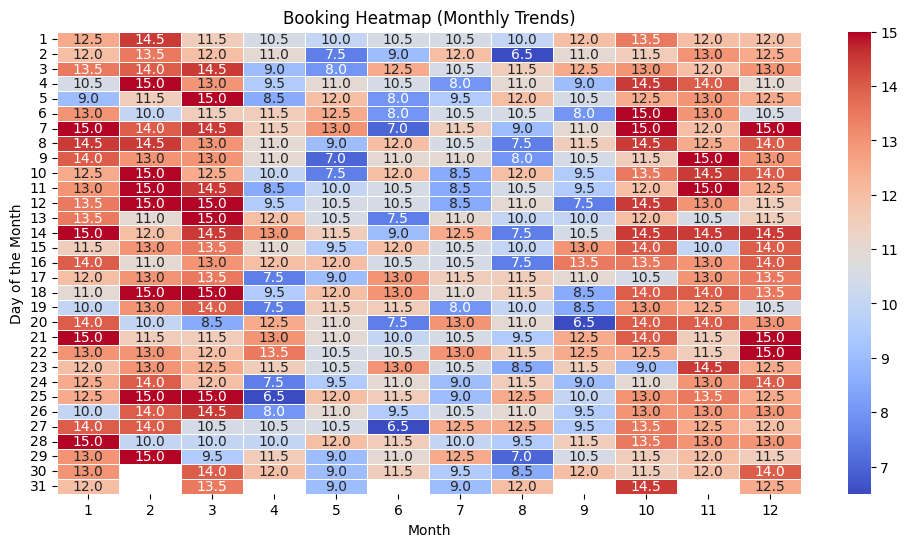

In [9]:
# Heatmap (Month vs Day)
df["DayOfMonth"] = df["Date"].dt.day
heatmap_data = df.pivot_table(index="DayOfMonth", columns="Month", values="Total Bookings", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Month")
plt.ylabel("Day of the Month")
plt.title("Booking Heatmap (Monthly Trends)")
plt.show()

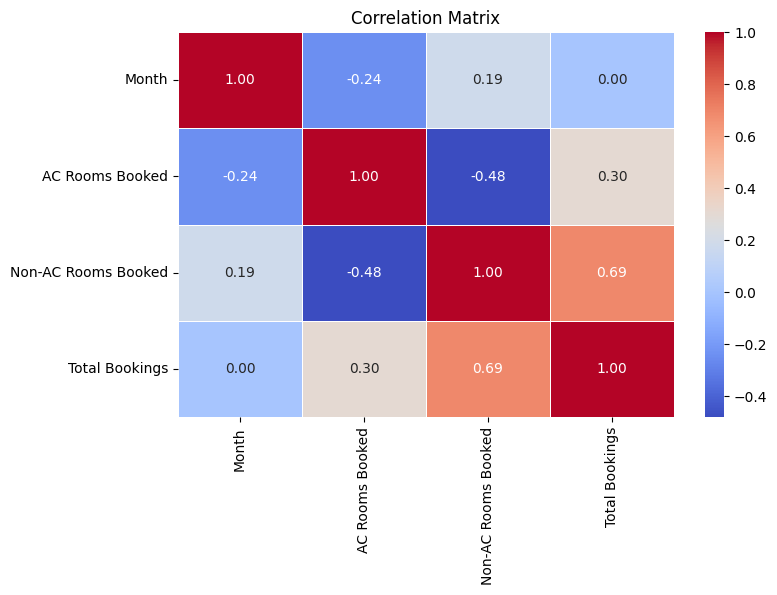

In [10]:

# Correlation Matrix
corr_matrix = df[["Month", "AC Rooms Booked", "Non-AC Rooms Booked", "Total Bookings"]].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
# Load dataset
def load_data():
    file_path = "room_bookings.xlsx"
    df = pd.read_excel(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    return df

In [13]:
df = load_data()
df.set_index("Date", inplace=True)
df = df.asfreq("D")  # Ensure daily frequency

In [14]:
# Train-test split (2023 = Train, 2024 = Test)
train = df[df.index.year == 2023]["Total Bookings"]
test = df[df.index.year == 2024]["Total Bookings"]

In [15]:
# Train SARIMA Model
sarima_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.forecast(steps=len(test))

In [16]:
# SARIMA Evaluation
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

In [17]:
# Train XGBoost Model
df_xgb = df.reset_index()
df_xgb["Day"] = df_xgb["Date"].dt.day
df_xgb["Weekday"] = df_xgb["Date"].dt.weekday

In [18]:
train_xgb = df_xgb[df_xgb["Year"] == 2023]
test_xgb = df_xgb[df_xgb["Year"] == 2024]

In [19]:
features = ["Month", "Day", "Weekday"]
X_train, y_train = train_xgb[features], train_xgb["Total Bookings"]
X_test, y_test = test_xgb[features], test_xgb["Total Bookings"]

In [20]:
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

In [21]:
# XGBoost Evaluation
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))

In [22]:
# Print model performance
print("📊 Model Performance Comparison:")
print(f"SARIMA - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")
print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")

📊 Model Performance Comparison:
SARIMA - MAE: 2.51, RMSE: 3.02
XGBoost - MAE: 1.86, RMSE: 2.36


In [24]:
# Save the best model (XGBoost in this case)
joblib.dump(xgb_model, "xgb_model.pkl")
print("✅ Best Model Saved: xgb_model.pkl")

✅ Best Model Saved: xgb_model.pkl


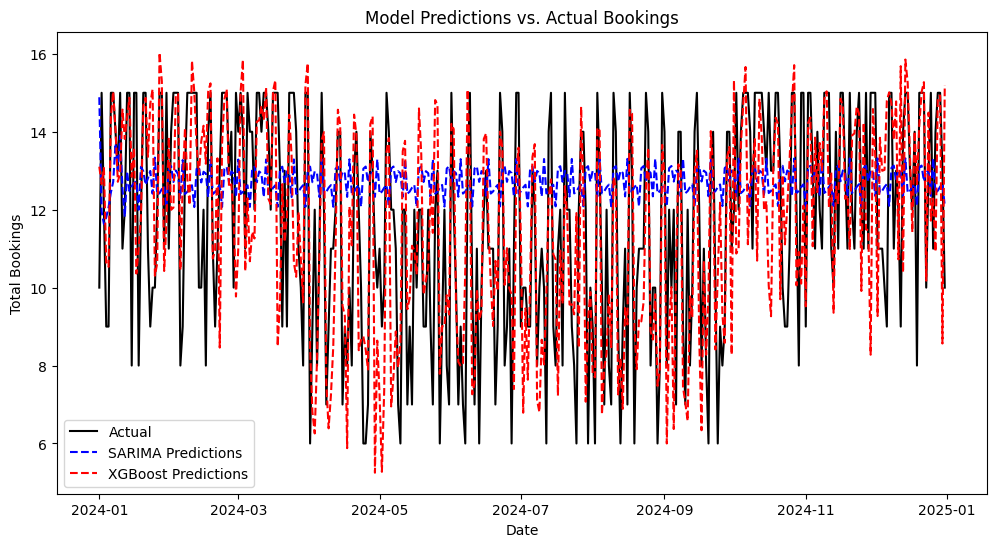

In [25]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual", color="black")
plt.plot(test.index, sarima_forecast, label="SARIMA Predictions", linestyle="dashed", color="blue")
plt.plot(test.index, xgb_forecast, label="XGBoost Predictions", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Total Bookings")
plt.legend()
plt.title("Model Predictions vs. Actual Bookings")
plt.show()